Running Adversarial Neuron Pruning

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load dataset

In [4]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify dataset

In [6]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9

In [7]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [8]:
# create a subset of the dataset
l = len(cifar10_train)
indices = np.arange(l)

In [9]:
np.random.seed(594462)
np.random.shuffle(indices)

# since we use 0.9 of the set as backdoored training set, we will use the rest 0.1 as fixing set
keep_indices = indices[int(l * poisoned_set_ratio):]

In [10]:
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

In [11]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [12]:
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=125, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

### Create and load the ResNet18

In [13]:
num_classes = 10

In [14]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda() if torch.cuda.is_available() else torch.nn.Linear(res18.fc.in_features, num_classes)

In [15]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [16]:
res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-200.pth'))

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_12828\3783847679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18.load_state_dict(torch.load(f'saved_models/ResNet18-CI

<All keys matched successfully>

### Create ANP wrapper

In [17]:
from ANP import *

In [18]:
anp_system = ANPWrapper(res18, tradeoff=0.2, lr=0.05, ep=0.4)

In [19]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(anp_system.weight_masks_optimizer, T_max=200)

In [20]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [21]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [22]:
test_acc_list = []
asr_list = []

# train for this many epochs
for epoch in range(50):
    anp_system.model.train()
    
    i = 0
    total_weight_masks_loss = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        # perform perturb step
        weight_masks_loss = anp_system.perturb_step(inputs, label)
        total_weight_masks_loss += weight_masks_loss
        # print(f'epoch: {epoch} | iteration: {i} | weight_mask_loss: {weight_masks_loss}')
        i += 1
    print(f'epoch: {epoch} | total_weight_masks_loss: {total_weight_masks_loss}')

    # in eval mode, we test backdoor effectiveness
    anp_system.model.eval()
    
    # testing loop (normal data)
    total_test_acc = 0
    test_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = anp_system.model(inputs)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    test_acc_list.append(total_test_acc/test_item_ct)
    
    # test with backdoor inserted to training set images
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = anp_system.model(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            backdoor_success_ct += np.sum(pred_lbls == 0)
            backdoor_item_ct += inputs.shape[0]
    
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    asr_list.append(backdoor_success_ct/backdoor_item_ct)

    scheduler.step()

epoch: 0 | total_weight_masks_loss: 126.68429812043905
Test Accuracy: 0.7581
Backdoor Success Rate: 1.0
epoch: 1 | total_weight_masks_loss: 102.1368183940649
Test Accuracy: 0.7428
Backdoor Success Rate: 0.9998
epoch: 2 | total_weight_masks_loss: 105.11793640255928
Test Accuracy: 0.7496
Backdoor Success Rate: 0.9995
epoch: 3 | total_weight_masks_loss: 100.81354035437107
Test Accuracy: 0.7594
Backdoor Success Rate: 0.9999
epoch: 4 | total_weight_masks_loss: 93.94137659668922
Test Accuracy: 0.7644
Backdoor Success Rate: 0.9991
epoch: 5 | total_weight_masks_loss: 94.00902006030083
Test Accuracy: 0.7836
Backdoor Success Rate: 0.9999
epoch: 6 | total_weight_masks_loss: 94.67131568491459
Test Accuracy: 0.7774
Backdoor Success Rate: 1.0
epoch: 7 | total_weight_masks_loss: 93.09848963469267
Test Accuracy: 0.7787
Backdoor Success Rate: 0.9998
epoch: 8 | total_weight_masks_loss: 91.85840229690075
Test Accuracy: 0.7689
Backdoor Success Rate: 0.9996
epoch: 9 | total_weight_masks_loss: 90.9640182703

In [23]:
import matplotlib.pyplot as plt

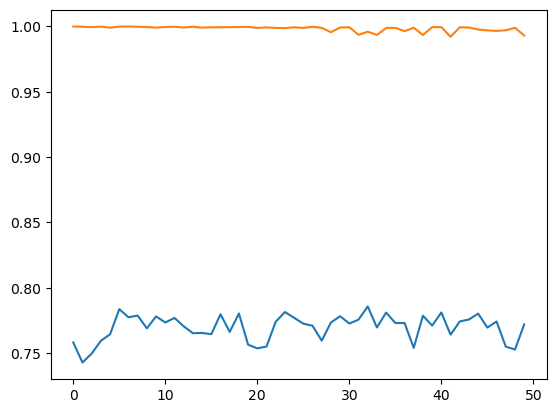

In [24]:
plt.plot(test_acc_list)
plt.plot(asr_list)

### Below are messy debug pokings

##### weight masks values histogram

In [25]:
all_masks_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_values.append(weight_mask_tensor.cpu().detach().numpy().flatten())

all_masks_values = np.concatenate(all_masks_values)

In [26]:
all_masks_values.shape

(9610,)

(array([3.700e+01, 2.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 5.000e+00,
        1.100e+01, 1.700e+01, 2.100e+01, 2.200e+01, 2.400e+01, 3.300e+01,
        3.800e+01, 5.300e+01, 7.400e+01, 1.180e+02, 1.510e+02, 2.200e+02,
        3.770e+02, 8.396e+03]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.45000002,
        0.5       , 0.55000001, 0.60000002, 0.65000004, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.90000004, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

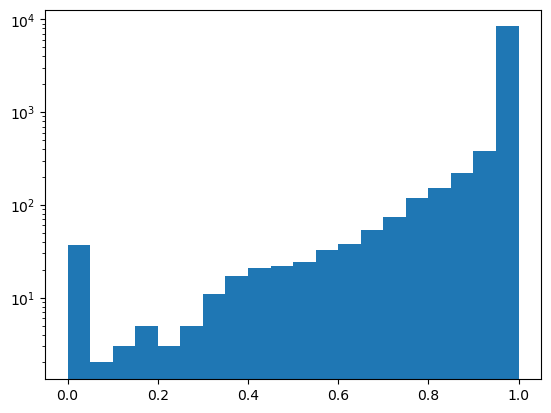

In [27]:
plt.hist(all_masks_values, bins=20, log=True)

(array([3.700e+01, 2.000e+00, 3.000e+00, 5.000e+00, 3.000e+00, 5.000e+00,
        1.100e+01, 1.700e+01, 2.100e+01, 2.200e+01, 2.400e+01, 3.300e+01,
        3.800e+01, 5.300e+01, 7.400e+01, 1.180e+02, 1.510e+02, 2.200e+02,
        3.770e+02, 8.396e+03]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.45000002,
        0.5       , 0.55000001, 0.60000002, 0.65000004, 0.69999999,
        0.75      , 0.80000001, 0.85000002, 0.90000004, 0.94999999,
        1.        ]),
 <BarContainer object of 20 artists>)

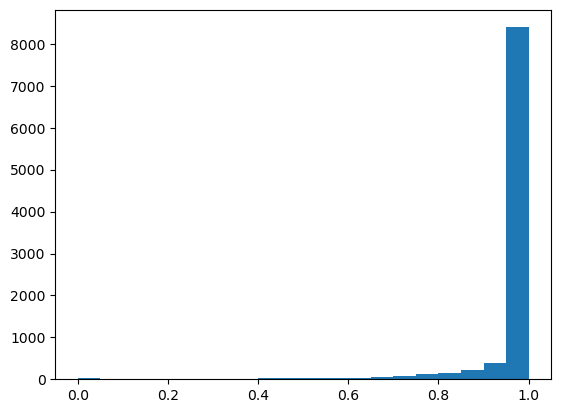

In [28]:
plt.hist(all_masks_values, bins=20)

In [29]:
# np.mean(all_masks_values)
np.std(all_masks_values)    # 0.0? they did not change at all!

np.float32(0.105880976)

In [30]:
all_masks_grad_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_grad_values.append(weight_mask_tensor.grad.cpu().detach().numpy().flatten())

all_masks_grad_values = np.concatenate(all_masks_grad_values)

##### perturbation values histogram

In [31]:
anp_system.layer_extra_params.keys()

dict_keys(['', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3', 'layer3.0', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4', 'layer4.0', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'layer4.1', 

In [32]:
anp_system.layer_extra_params['conv1']

{'m': tensor([[[[0.9999]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9999]]],
 
 
         [[[0.9998]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9998]]],
 
 
         [[[0.9998]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9999]]],
 
 
         [[[0.9999]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9997]]],
 
 
         [[[0.9999]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9999]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9999]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[1.0000]]],
 
 
         [[[0.9997]]],
 
 
         [[[0.9997]]],
 
 
         [[[1.0000]]],


In [33]:
all_perturbations_values = []

for name in anp_system.weight_perturbations:
    weight_perturbation_tensor = anp_system.weight_perturbations[name]
    all_perturbations_values.append(weight_perturbation_tensor.cpu().detach().numpy().flatten())

all_perturbations_values = np.concatenate(all_perturbations_values)

In [34]:
all_perturbations_values.shape

(9610,)

(array([5617.,   49.,   45.,   44.,   50.,   52.,   48.,   50.,   52.,
          58.,   56.,   53.,   52.,   41.,   56.,   46.,   48.,   53.,
          52., 3088.]),
 array([-4.00000006e-01, -3.60000014e-01, -3.19999993e-01, -2.80000001e-01,
        -2.40000010e-01, -2.00000018e-01, -1.60000011e-01, -1.20000005e-01,
        -8.00000131e-02, -4.00000215e-02, -2.98023224e-08,  3.99999917e-02,
         7.99999833e-02,  1.19999975e-01,  1.59999996e-01,  1.99999958e-01,
         2.39999980e-01,  2.80000001e-01,  3.19999963e-01,  3.59999985e-01,
         4.00000006e-01]),
 <BarContainer object of 20 artists>)

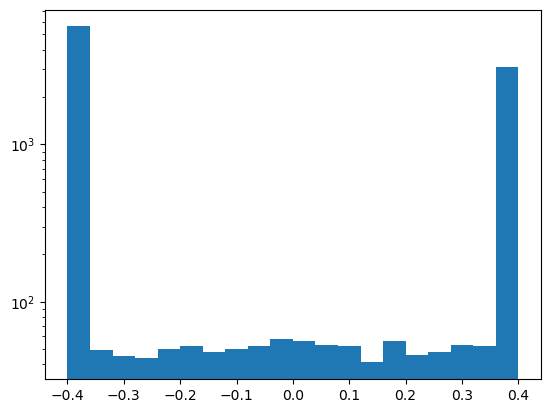

In [35]:
plt.hist(all_perturbations_values, bins=20, log=True)

##### confirms that the param tensors are same objects

In [36]:
anp_system.weight_perturbations['fc.weight'].grad

In [37]:
anp_system.weight_perturbations['fc.weight'] is anp_system.layer_extra_params['fc']['delta']

True

In [38]:
anp_system.weight_masks['fc.weight'] is anp_system.layer_extra_params['fc']['m']

True

In [39]:
anp_system.weight_masks['conv1.weight'] is anp_system.layer_extra_params['conv1']['m']

True

In [40]:
anp_system.layer_extra_params['conv1']['m'].requires_grad

True

##### regarding values of the tensors

In [41]:
torch.amin(anp_system.layer_extra_params['conv1']['m'])

tensor(0.9996, device='cuda:0', grad_fn=<AminBackward0>)

In [42]:
anp_system.layer_extra_params['conv1']['m'].min()

tensor(0.9996, device='cuda:0', grad_fn=<MinBackward1>)

In [43]:
anp_system.ep

0.4

In [44]:
anp_system.weight_perturbations['fc.weight']

tensor([[-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [ 0.4000],
        [-0.4000],
        [ 0.4000],
        [-0.4000]], device='cuda:0')

In [45]:
anp_system.weight_perturbations['fc.weight'].clamp(-0.4, 0.4)

tensor([[-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [ 0.4000],
        [-0.4000],
        [ 0.4000],
        [-0.4000]], device='cuda:0')

In [46]:
anp_system.weight_perturbations['fc.weight']

tensor([[-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [-0.4000],
        [ 0.4000],
        [-0.4000],
        [ 0.4000],
        [-0.4000]], device='cuda:0')

##### shape of parameters

In [47]:
anp_system.layer_extra_params['conv1']['m'].shape

torch.Size([64, 1, 1, 1])

In [48]:
anp_system.layer_extra_params['fc']['m'].shape

torch.Size([10, 1])

In [49]:
anp_system.layer_extra_params['fc']['delta'].shape

torch.Size([10, 1])

In [50]:
anp_system.layer_extra_params['fc']['xi'].shape

torch.Size([10])

In [51]:
anp_system.layer_extra_params['conv1']['delta'].shape

torch.Size([64, 1, 1, 1])

In [52]:
anp_system.layer_extra_params['layer1.0.conv1']['delta'].shape

torch.Size([64, 1, 1, 1])

In [53]:
anp_system.layer_extra_params['layer2.0.conv2']['delta'].shape


torch.Size([128, 1, 1, 1])

In [54]:
anp_system.layer_extra_params['layer2.1.conv2']['delta'].shape


torch.Size([128, 1, 1, 1])

In [55]:
za = torch.ones(anp_system.layer_extra_params['layer2.1.conv2']['delta'].shape[:1]).cuda()

In [56]:
za.shape

torch.Size([128])

In [57]:
num_neurons = 0

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    num_neurons += weight_mask_tensor.shape[0]

num_neurons

9610

In [58]:
1 + za

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2.], device='cuda:0')

In [59]:
ga = torch.ones(anp_system.layer_extra_params['fc']['delta'].shape[:1]).cuda()

In [60]:
((1 + ga) * anp_system.layer_extra_params['fc']['delta'].T).T

tensor([[-0.8000],
        [-0.8000],
        [-0.8000],
        [-0.8000],
        [-0.8000],
        [-0.8000],
        [ 0.8000],
        [-0.8000],
        [ 0.8000],
        [-0.8000]], device='cuda:0')

In [61]:
((1 + ga) * anp_system.layer_extra_params['fc']['delta'].T).T == 2 * anp_system.layer_extra_params['fc']['delta']

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

In [62]:
torch.all(((1 + ga) * anp_system.layer_extra_params['fc']['delta'].T).T == 2 * anp_system.layer_extra_params['fc']['delta'])

tensor(True, device='cuda:0')

In [63]:
anp_system.layer_extra_params['layer2.1.conv2']['delta'].T.shape

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_12828\3547231238.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3687.)
  anp_system.layer_extra_params['layer2.1.conv2']['delta'].T.shape


torch.Size([1, 1, 1, 128])

In [64]:
torch.all(((1 + za) * anp_system.layer_extra_params['layer2.1.conv2']['delta'].T).T == 2 * anp_system.layer_extra_params['layer2.1.conv2']['delta'])

tensor(True, device='cuda:0')

In [65]:
# torch.mul((1 + za), anp_system.layer_extra_params['layer2.1.conv2']['delta'], axis=0)

In [66]:
t_dim = len(anp_system.layer_extra_params['layer2.1.conv2']['delta'].shape)
n_dim = [anp_system.layer_extra_params['layer2.1.conv2']['delta'].shape[0],] + [1,] * (t_dim - 1)
zza = torch.ones(n_dim).cuda()

In [67]:
zza.shape

torch.Size([128, 1, 1, 1])

In [68]:
torch.all((1 + zza) * anp_system.layer_extra_params['layer2.1.conv2']['delta'] == 2 * anp_system.layer_extra_params['layer2.1.conv2']['delta'])

tensor(True, device='cuda:0')

In [69]:
t_dim = len(anp_system.layer_extra_params['fc']['delta'].shape)
n_dim = [anp_system.layer_extra_params['fc']['delta'].shape[0],] + [1,] * (t_dim - 1)
gga = torch.ones(n_dim).cuda()

In [70]:
gga.shape

torch.Size([10, 1])

In [71]:
torch.all((1 + gga) * anp_system.layer_extra_params['fc']['delta'] == 2 * anp_system.layer_extra_params['fc']['delta'])

tensor(True, device='cuda:0')

In [72]:
torch.__version__

'2.5.1'